<a href="https://colab.research.google.com/github/mahamapara/CS152_BDL/blob/main/cs152_lect3_C_NeuralNetsJAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural nets from scratch in JAX

In this notebook, we'll cover

* Part 0: Simple neural network data struct via a list-of-dicts (which JAX views as a PyTree)
* Part 1: Prediction with neural nets
* Part 2: Training neural nets
* * 2A: Fitting 0-hidden-layer NNs
* * 2B: Fitting 1-hidden-layer NNs with 16 units
* Part 3: Speeding up training by ~60x with `jax.jit()`

# Prerequisites

We're expecting you've already seen Neural Nets in a previous ML course.

This notebook is a practical refresher, showing how we can implement non-trivial feed-forward neural nets "from scratch"

You should have already completed the [day03-A : Auto Diff with JAX](https://github.com/tufts-ml-courses/cs152BDL-22f-assignments/blob/main/day03-A-AutoDifferentiationJAX.ipynb) notebook, where you'd learn:

* how to use `jax.grad(...)`
* what a PyTree is within the jax library

You should have also completed the [day03-B : Gradient Descent with JAX](https://github.com/tufts-ml-courses/cs152BDL-22f-assignments/blob/main/day03-B-GradientDescentJAX.ipynb) notebook, where you'd refresh on

* basics of gradient descent
* how we can use toy data to create testbeds for learning algorithms

We'll use the same toy data in this notebook.

# Requirements

There are two ways to run this notebook

<table style="table-medium">
    <tr>
        <td style="align:left; text-align:left;"> <h2> Run in-browser (no install necessary) </h2>
        </td>
        <td style="align:left; text-align:left;"> <h2> Run locally on your computer </h2>
        </td>        
    </tr>
    <tr>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://colab.research.google.com/">Google Colab </a> </p>
             <p>You'll need:</p>
             <ul>
             <li> internet connection </li>
             <li>  Modern browser (Firefox, Chrome, Safari, Edge, etc) </li>
             <li> Google account </li>
             <li> Warning: session will timeout after 12 hours, or sooner if inactive </li>
             <li> Plan to save work if you want it later </li>
         </ul></td>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://jupyter.org/">Jupyter notebook </a> </p>
             <p>You'll need:</p>             <ul>
             <li> Linux, Mac OS or other modern Unix-based OS (sorry, Windows + JAX is difficult) </li>
             <li> Conda package manager </li>
             <li> Python 3.8+ </li>
             <li> All packages from <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/bdl_2022f_env.html">bdl_2022f_env</a> 
                 , see <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/setup_python_env.html">
                 Install Instructions on Course Website </a>
             </li>
         </ul></td>
    </tr>
</table>


In [1]:
# Import numpy and other basic libraries
import numpy as np
import pandas as pd
import time, os, platform

In [2]:
## Import JAX
import jax.numpy as jnp
import jax

In [3]:
# Import packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

## Report OS and CPU information

In [4]:
uname = platform.uname()
B = 10
print("="*B, "Information about OS and CPU", "="*B)
print(f"Node Name: {uname.node}")
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}  Processor: {uname.processor}")
print("Num cores: ", os.cpu_count())

========== Information about OS and CPU ==========
Node Name: 378455ae3e44
System: Linux
Version: #1 SMP Fri Aug 26 08:44:51 UTC 2022
Machine: x86_64  Processor: x86_64
Num cores:  2


## Report exact versions of required packages in local env

In [5]:
print("="*B, "Packages in local env", "="*B)
for pkg in [np, jax, matplotlib, sns]:
  print("%12s %s" % (pkg.__name__, pkg.__version__))

========== Packages in local env ==========
       numpy 1.21.6
         jax 0.3.17
  matplotlib 3.2.2
     seaborn 0.11.2


# Part 0: List-of-dicts PyTree as a data struct for a Neural Net

### Function to create a neural net of desired size

In [6]:
def make_nn_params_as_list_of_dicts(
        n_dims_input=1,
        n_dims_output=1,
        n_dims_per_hidden_list=[5],
        weight_fill_func=np.zeros,
        bias_fill_func=np.zeros):
    ''' Create a list of dicts structure defining a neural network
    
    Args
    ----
    n_dims_input : int
    n_dims_output : int
    n_hiddens_per_layer_list : list of int
    weight_fill_func : callable, like np.zeros
    bias_fill_func : callable, like np.zeros
    
    Returns
    -------
    nn_params : list of dicts
        Each dict has two keys, 'w' and 'b', for weights and biases
        The values are arrays of the specified shape.
    '''
    nn_param_list = []
    n_per_layer_list = [n_dims_input] + n_dims_per_hidden_list + [n_dims_output]

    # Given full network size list is [a, b, c, d, e]
    # Loop over adjacent pairs: (a,b) , (b,c) , (c,d) , (d,e)
    for n_in, n_out in zip(n_per_layer_list[:-1], n_per_layer_list[1:]):
        nn_param_list.append(
            dict(
                w=weight_fill_func((n_in, n_out)),
                b=bias_fill_func((n_out,)),
            ))
    return nn_param_list

### Utility func: Pretty print the contents of a list of dicts representation

In [7]:
def pretty_print_nn_param_list(nn_param_list_of_dict):
    ''' Create pretty display of the parameters at each layer
    '''
    with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
        for ll, layer_dict in enumerate(nn_param_list_of_dict):
            print("Layer %d" % ll)
            print("  w | shape %9s | %s" % (layer_dict['w'].shape, layer_dict['w'].flatten()))
            print("  b | shape %9s | %s" % (layer_dict['b'].shape, layer_dict['b'].flatten()))

### Utility funcs: Subtraction and multiplication

In [8]:
def subtract_pytree_and_scalar(a_pytree, b):
    ''' Add the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree - b
    '''
    return jax.tree_map(lambda a: a - b, a_pytree)

def subtract_pytrees(a_pytree, b_pytree):
    ''' Subtract one pytree from another
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree - b_pytree
    '''
    return jax.tree_map(lambda a,b: a - b, a_pytree, b_pytree)

In [9]:
def multiply_pytree_and_scalar(a_pytree, b):
    ''' Multiply the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree * b
    '''
    return jax.tree_map(lambda a: a * b, a_pytree)

def eltwise_multiply_pytrees(a_pytree, b_pytree):
    ''' Multiply corresponding elts of two pytrees
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree * b_pytree
    '''
    return jax.tree_map(lambda a,b: a*b,
            a_pytree, b_pytree,
        )

### Example: NN for 1 input, 1 output and no hidden layers

For univariate regression: 1D -> 1D

Will fill all parameters with zeros by default

In [10]:
nn11_params = make_nn_params_as_list_of_dicts(
    n_dims_input=1,
    n_dims_output=1,
    n_dims_per_hidden_list=[])

In [11]:
nn11_params

[{'w': array([[0.]]), 'b': array([0.])}]

In [12]:
pretty_print_nn_param_list(nn11_params)

Layer 0
  w | shape    (1, 1) | [ 0.000]
  b | shape      (1,) | [ 0.000]


### Example: NN for 3 input, 1 output and no hidden layers

For regression problems that project 3D -> 1D

In [13]:
nn31_params = make_nn_params_as_list_of_dicts(
    n_dims_input=3,
    n_dims_output=1,
    n_dims_per_hidden_list=[])
pretty_print_nn_param_list(nn31_params)

Layer 0
  w | shape    (3, 1) | [ 0.000  0.000  0.000]
  b | shape      (1,) | [ 0.000]


### Example: NN for 3 input, 1 output and 1 hidden layer of size 4


In [14]:
nn341_params = make_nn_params_as_list_of_dicts(
    n_dims_input=3,
    n_dims_output=1,
    n_dims_per_hidden_list=[4])
pretty_print_nn_param_list(nn341_params)

Layer 0
  w | shape    (3, 4) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000]
  b | shape      (4,) | [ 0.000  0.000  0.000  0.000]
Layer 1
  w | shape    (4, 1) | [ 0.000  0.000  0.000  0.000]
  b | shape      (1,) | [ 0.000]


### Same as above, but fill with random values from interval [-1, 1]

In [15]:
fill_random_between_neg_one_and_one = lambda shape: np.random.RandomState(0)\
    .uniform(low=-1, high=1, size=shape)
fill_random_between_neg_tenth_and_tenth = lambda shape: np.random.RandomState(0)\
    .uniform(low=-.1, high=.1, size=shape)

In [16]:
nn341_params = make_nn_params_as_list_of_dicts(
    n_dims_input=3,
    n_dims_output=1,
    n_dims_per_hidden_list=[4],
    weight_fill_func=fill_random_between_neg_one_and_one,
    bias_fill_func=fill_random_between_neg_one_and_one)
pretty_print_nn_param_list(nn341_params)

Layer 0
  w | shape    (3, 4) | [ 0.098  0.430  0.206  0.090 -0.153  0.292 -0.125  0.784  0.927 -0.233
  0.583  0.058]
  b | shape      (4,) | [ 0.098  0.430  0.206  0.090]
Layer 1
  w | shape    (4, 1) | [ 0.098  0.430  0.206  0.090]
  b | shape      (1,) | [ 0.098]


### NN for 3 input, 1 output with 7 layers of different sizes

In [17]:
nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=1,
    n_dims_output=1,
    n_dims_per_hidden_list=[2, 4, 8, 2, 8, 4, 2])
pretty_print_nn_param_list(nn_params)

Layer 0
  w | shape    (1, 2) | [ 0.000  0.000]
  b | shape      (2,) | [ 0.000  0.000]
Layer 1
  w | shape    (2, 4) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
  b | shape      (4,) | [ 0.000  0.000  0.000  0.000]
Layer 2
  w | shape    (4, 8) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000]
  b | shape      (8,) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
Layer 3
  w | shape    (8, 2) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000]
  b | shape      (2,) | [ 0.000  0.000]
Layer 4
  w | shape    (2, 8) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000]
  b | shape      (8,) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
Layer 5
 

# Part 1: Prediction with Neural Nets

### Use the tanh function as activation

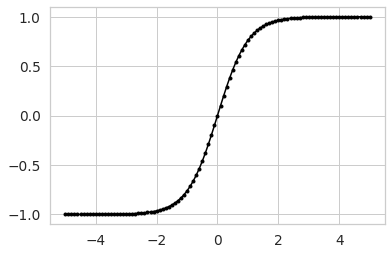

In [18]:
H = 101
in_H = np.linspace(-5, 5, H)
out_H = jnp.tanh(in_H);
plt.plot(in_H, out_H, 'k.-');

### Define function for prediction

In [19]:
def predict_y_given_x_with_NN(x=None, nn_param_list=None, activation_func=jnp.tanh):
    """ Predict y value given x value via feed-forward neural net
    
    Args
    ----
    x_ND : 2D array, shape (N,D) = (n_examples, n_input_dims)
        D-dim feature vector for each example
    nn_param_list : list of dict
        Parameters of neural network
    activation_func : callable
        Activation function of the neural net
        Must be differentiable using jax.grad

    Returns
    -------
    y_N : 1D array, shape (N,) = (n_examples,)
        Predicted value for each example
    """
    n_layers = len(nn_param_list)
    in_arr = jnp.atleast_2d(x)
    for layer_id, layer_dict in enumerate(nn_param_list):
        out_arr = jnp.dot(in_arr, layer_dict['w']) + layer_dict['b']
        if layer_id < n_layers:
            in_arr = activation_func(out_arr)
    # Squeeze so returned shape becomes (n_dims_out,) not (n_dims_out,1)
    return jnp.squeeze(out_arr)

### Create Toy Dataset of (x,y) via linear regression

In [20]:
N = 300
D = 2
sigma = 0.1

true_w_D = np.asarray([.42, -.42])

train_prng = np.random.RandomState(0)
x_ND = train_prng.uniform(low=-3, high=3, size=(N,D))
y_N = np.dot(x_ND, true_w_D) + sigma * train_prng.randn(N)

### Create NN with no hiddens, filled with the true params used to create our data

Goal here is to verify we can almost perfectly predict the observed data (since we're using the true model)

In [21]:
true_nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=2,
    n_dims_output=1,
    n_dims_per_hidden_list=[])
true_nn_params[0]['w'][:] = true_w_D[:,np.newaxis]
true_nn_params[0]['b'][:] = 0.0

In [22]:
yhat_N = predict_y_given_x_with_NN(x_ND, true_nn_params)
assert yhat_N.size == N

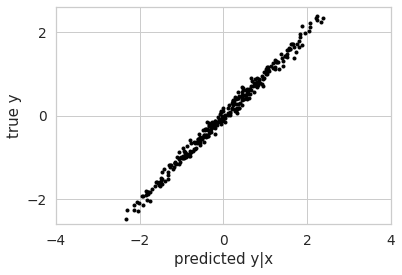

In [23]:
plt.plot(yhat_N, y_N, 'k.')
plt.ylabel('true y')
plt.xlabel('predicted y|x');
plt.axis('equal'); plt.xticks([-4, -2, 0, 2, 4]); plt.yticks([-4, -2, 0, 2, 4]);

### Create NN filled with random weight values

Goal is to understand how accurate a "random" neural net would be

In [24]:
rand_nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=2,
    n_dims_output=1,
    n_dims_per_hidden_list=[2],
    weight_fill_func=fill_random_between_neg_one_and_one,
    bias_fill_func=fill_random_between_neg_one_and_one)

In [25]:
yhat_N = predict_y_given_x_with_NN(x_ND, rand_nn_params)
assert yhat_N.size == N

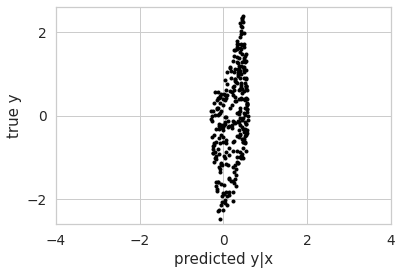

In [26]:
plt.plot(yhat_N, y_N, 'k.')
plt.ylabel('true y')
plt.xlabel('predicted y|x');
plt.axis('equal'); plt.xticks([-4, -2, 0, 2, 4]); plt.yticks([-4, -2, 0, 2, 4]);

# Part 2: Training a Neural Net via gradient descent

### Define loss function as per-example squared error

We can define the following:

* Parameters $\theta$ : All the weights and bias parameters of our neural net

* Loss function $\mathcal{L}(\theta)$
$$\mathcal{L}(\theta; \mathbf{x}_{1:N}, \mathbf{y}_{1:N}) = -\frac{1}{2 \sigma^2} \frac{1}{N} \sum_{n=1}^N (y_n - f_{\theta}(x_n))^2
$$

Training optimization problem:

$$
\arg,\min_{\theta} \mathcal{L}( \theta )
$$

In [27]:
def calc_loss__mean_squared_error(nn_param_pytree):
    ''' Calculate the mean squared error loss 
    
    Args
    ----
    nn_param_pytree : PyTree list of dict
        Neural net
        
    Returns
    -------
    error : scalar float
        Mean squared error value on our dataset
    '''
    yhat_N = predict_y_given_x_with_NN(x_ND, nn_param_pytree)
    assert yhat_N.shape == y_N.shape
    mean_squared_error = 0.5 / jnp.square(sigma) * jnp.mean(jnp.square(y_N - yhat_N))
    return mean_squared_error

### Use jax.value_and_grad to compute the grad alongside the loss

JAX's built-in `value_and_grad` will compute the loss function and its grad in one function,
returning a tuple containing the loss (as a scalar float) and the gradient (as a pytree)

Using this one function is more efficient if we're ALWAYS going to ask for both loss and gradient.

Otherwise, we'd redundantly do multiple forward passes thru the network (one for calc_loss, one for calc_grad)



In [28]:
calc_loss_and_grad = jax.value_and_grad(calc_loss__mean_squared_error)

In [29]:
loss, g = calc_loss_and_grad(rand_nn_params)

In [30]:
loss

DeviceArray(51.312622, dtype=float32)

### Define a gradient descent procedure that uses our list-of-dicts representation

In [31]:
def run_many_iters_of_grad_descent(
        calc_loss_and_grad,
        init_nn_param_pytree,
        n_iters=100, step_size=0.001,
        print_every=None):
    ''' Run many iterations of gradient descent
    
    Args
    ----
    calc_loss_and_grad : function
        Computes the loss and gradient that we want to minimize
        By using ONE function, we can avoid duplicating passes thru our neural net (saving time)
        
    init_nn_param_pytree : PyTree list of dicts
        Initial value of neural net parameters
    
    Returns
    -------
    opt_nn_param_pytree : PyTree list of dicts
        Final value of neural net parameters
        If converged, should be local optima of loss function
    history : dict of lists
        Provides history of the function value and other useful summaries
    '''
    # Copy the initial parameters
    nn_param_pytree = multiply_pytree_and_scalar(init_nn_param_pytree, 1.0)
    
    # Create data structs to track per-iteration history
    # of different quantities
    history = dict(
        iter=[],
        loss=[],
        param_values=[],
        gradient_values=[])

    start_time = time.time()
    grad_pytree = None # Will be overwritten later
    for iter_id in range(n_iters+1):
        if iter_id > 0:                
            # x <- x - step_size * g
            nn_param_pytree = subtract_pytrees(nn_param_pytree,
                multiply_pytree_and_scalar(grad_pytree, step_size))

        loss, grad_pytree = calc_loss_and_grad(nn_param_pytree)
        history['iter'].append(iter_id)
        history['loss'].append(loss)
        history['param_values'].append(nn_param_pytree)
        history['gradient_values'].append(grad_pytree)
        
        if isinstance(print_every, int) and iter_id % print_every == 0:
            print("iter %4d/%d after %5.1f sec : loss %11.6f" % (
                iter_id, n_iters, time.time() - start_time, history['loss'][-1]))
    return nn_param_pytree, history

## Example 2A: Linear regression with our Neural Net framework

We'll use the above procedures to fit a 0-hidden-layer neural network

This is just a sanity check to be sure everything is working.

### First, try with initialization to TRUE PARAMETERS

In [32]:
print("INITIAL PARAMETERS (true)")
pretty_print_nn_param_list(true_nn_params)

INITIAL PARAMETERS (true)
Layer 0
  w | shape    (2, 1) | [ 0.420 -0.420]
  b | shape      (1,) | [ 0.000]


In [33]:
fromtrue_opt_nn_params, fromtrue_history = run_many_iters_of_grad_descent(
    calc_loss_and_grad,
    true_nn_params,
    n_iters=200,
    step_size=0.001,
    print_every=10)

iter    0/200 after   0.1 sec : loss    0.544268
iter   10/200 after   0.2 sec : loss    0.533351
iter   20/200 after   0.3 sec : loss    0.532404
iter   30/200 after   0.4 sec : loss    0.532289
iter   40/200 after   0.5 sec : loss    0.532275
iter   50/200 after   0.5 sec : loss    0.532273
iter   60/200 after   0.6 sec : loss    0.532273
iter   70/200 after   0.7 sec : loss    0.532273
iter   80/200 after   0.8 sec : loss    0.532273
iter   90/200 after   0.9 sec : loss    0.532273
iter  100/200 after   0.9 sec : loss    0.532273
iter  110/200 after   1.0 sec : loss    0.532273
iter  120/200 after   1.1 sec : loss    0.532273
iter  130/200 after   1.1 sec : loss    0.532273
iter  140/200 after   1.2 sec : loss    0.532273
iter  150/200 after   1.3 sec : loss    0.532273
iter  160/200 after   1.4 sec : loss    0.532273
iter  170/200 after   1.4 sec : loss    0.532273
iter  180/200 after   1.5 sec : loss    0.532273
iter  190/200 after   1.6 sec : loss    0.532273
iter  200/200 after 

In [34]:
print("\nFINAL PARAMETERS from true init")
pretty_print_nn_param_list(fromtrue_opt_nn_params)


FINAL PARAMETERS from true init
Layer 0
  w | shape    (2, 1) | [ 0.422 -0.424]
  b | shape      (1,) | [-0.013]


### Now, try with initialization to ALL ZEROS

In [35]:
zero_nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=2,
    n_dims_output=1,
    n_dims_per_hidden_list=[],
    weight_fill_func=np.zeros,
    bias_fill_func=np.zeros)

print("INITIAL PARAMETERS (all zero)")
pretty_print_nn_param_list(zero_nn_params)

INITIAL PARAMETERS (all zero)
Layer 0
  w | shape    (2, 1) | [ 0.000  0.000]
  b | shape      (1,) | [ 0.000]


In [36]:
fromzero_opt_nn_params, fromzero_history = run_many_iters_of_grad_descent(
    calc_loss_and_grad,
    zero_nn_params,
    n_iters=200,
    step_size=0.0005,
    print_every=10)

print("\nFINAL PARAMETERS from all-zero init")
pretty_print_nn_param_list(fromzero_opt_nn_params)

iter    0/200 after   0.0 sec : loss   57.105030
iter   10/200 after   0.1 sec : loss    2.362893
iter   20/200 after   0.2 sec : loss    0.595087
iter   30/200 after   0.2 sec : loss    0.535033
iter   40/200 after   0.3 sec : loss    0.532580
iter   50/200 after   0.4 sec : loss    0.532359
iter   60/200 after   0.5 sec : loss    0.532303
iter   70/200 after   0.6 sec : loss    0.532284
iter   80/200 after   0.6 sec : loss    0.532277
iter   90/200 after   0.8 sec : loss    0.532275
iter  100/200 after   0.8 sec : loss    0.532274
iter  110/200 after   0.9 sec : loss    0.532273
iter  120/200 after   1.0 sec : loss    0.532273
iter  130/200 after   1.1 sec : loss    0.532273
iter  140/200 after   1.2 sec : loss    0.532273
iter  150/200 after   1.2 sec : loss    0.532273
iter  160/200 after   1.3 sec : loss    0.532273
iter  170/200 after   1.4 sec : loss    0.532273
iter  180/200 after   1.5 sec : loss    0.532273
iter  190/200 after   1.6 sec : loss    0.532273
iter  200/200 after 

### Fig 2A(i): History of the loss over iterations from all-zero init

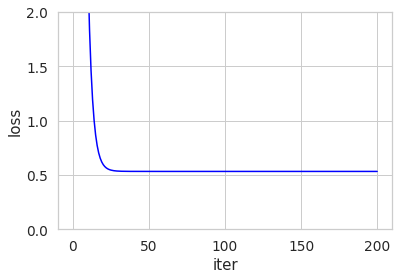

In [37]:
plt.plot(fromzero_history['iter'], fromzero_history['loss'], 'b-')
plt.xlabel('iter');
plt.ylabel('loss');
plt.ylim([0, 2.]); # Truncate the y-axis to focus on later stages of learning

### Fig 2A(ii): Predictive scatterplot at select iterations

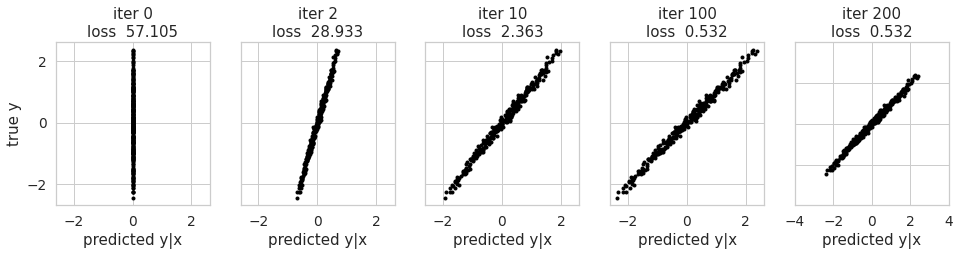

In [38]:
_, axgrid = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(16, 3))
for ii, iternum in enumerate([0, 2, 10, 100, 200]):
    yhat_N = predict_y_given_x_with_NN(x_ND, fromzero_history['param_values'][iternum])
    ax = axgrid[ii]
    ax.plot(yhat_N, y_N, 'k.')

    if ii == 0:
        ax.set_ylabel('true y')
    ax.set_xlabel('predicted y|x');
    ax.set_xticks([-4, -2, 0, 2, 4]); ax.set_yticks([-4, -2, 0, 2, 4]);
    ax.set_title("iter %d\nloss % .3f" % (iternum, fromzero_history['loss'][iternum]))

## Example 2B: Regression with a 2-16-1 neural network

Let's try to fit a more complex neural network, with 16 hidden units

Yes, the true data is linear, but we should be able to fit that well even though our model is non-linear.

In [39]:
rand_nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=2,
    n_dims_output=1,
    n_dims_per_hidden_list=[16],
    weight_fill_func=fill_random_between_neg_tenth_and_tenth,
    bias_fill_func=np.zeros)

print("INITIAL PARAMETERS")
pretty_print_nn_param_list(rand_nn_params)

INITIAL PARAMETERS
Layer 0
  w | shape   (2, 16) | [ 0.010  0.043  0.021  0.009 -0.015  0.029 -0.012  0.078  0.093 -0.023
  0.058  0.006  0.014  0.085 -0.086 -0.083 -0.096  0.067  0.056  0.074
  0.096  0.060 -0.008  0.056 -0.076  0.028 -0.071  0.089  0.004 -0.017
 -0.047  0.055]
  b | shape     (16,) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000]
Layer 1
  w | shape   (16, 1) | [ 0.010  0.043  0.021  0.009 -0.015  0.029 -0.012  0.078  0.093 -0.023
  0.058  0.006  0.014  0.085 -0.086 -0.083]
  b | shape      (1,) | [ 0.000]


### Run gradient descent from this random init

This should take about 1-4 minutes to complete on a modern computer.

Note: choice of init/step size is much more sensitive here...

In [40]:
fromrand_opt_nn_params, fromrand_history = run_many_iters_of_grad_descent(
    calc_loss_and_grad,
    rand_nn_params,
    n_iters=5000,
    step_size=0.0008,
    print_every=200)

iter    0/5000 after   0.3 sec : loss   51.275570
iter  200/5000 after   2.5 sec : loss    0.782339
iter  400/5000 after   4.6 sec : loss    0.689088
iter  600/5000 after   6.6 sec : loss    0.645407
iter  800/5000 after   8.7 sec : loss    0.619947
iter 1000/5000 after  10.7 sec : loss    0.603375
iter 1200/5000 after  12.8 sec : loss    0.591968
iter 1400/5000 after  14.8 sec : loss    0.583851
iter 1600/5000 after  16.8 sec : loss    0.577917
iter 1800/5000 after  18.9 sec : loss    0.573451
iter 2000/5000 after  20.9 sec : loss    0.569982
iter 2200/5000 after  22.9 sec : loss    0.567198
iter 2400/5000 after  25.0 sec : loss    0.564896
iter 2600/5000 after  27.1 sec : loss    0.562940
iter 2800/5000 after  29.1 sec : loss    0.561245
iter 3000/5000 after  31.2 sec : loss    0.559750
iter 3200/5000 after  33.3 sec : loss    0.558415
iter 3400/5000 after  35.3 sec : loss    0.557211
iter 3600/5000 after  37.3 sec : loss    0.556116
iter 3800/5000 after  39.4 sec : loss    0.555114


### Fig 2B(i): History of the loss

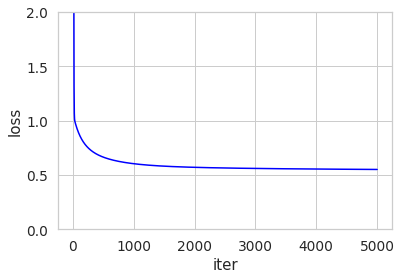

In [41]:
plt.plot(fromrand_history['iter'], fromrand_history['loss'], 'b-')
plt.xlabel('iter');
plt.ylabel('loss');
plt.ylim([0, 2.]); # Truncate the y-axis to focus on later stages of learning

### Fig 2B(ii): History of the sum of absolute values of the gradient

In [42]:
# To better understand convergence, we often plot the gradient over time
# for NNs with many parameters, we can look at the sum of absolute values of the gradient
fromrand_history['gradL1norm'] = []
for grad_pytree in fromrand_history['gradient_values']:
    list_of_arr = jax.tree_util.tree_leaves(grad_pytree)
    fromrand_history['gradL1norm'].append(np.sum([np.sum(np.abs(a)) for a in list_of_arr]))

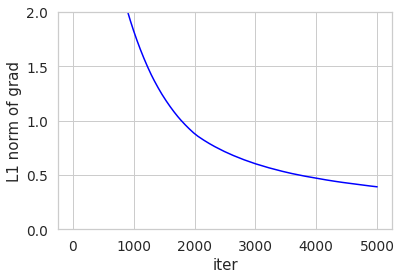

In [43]:
plt.plot(fromrand_history['iter'], fromrand_history['gradL1norm'], 'b-')
plt.xlabel('iter');
plt.ylabel('L1 norm of grad');
plt.ylim([0, 2.]); # Truncate the y-axis to focus on later stages of learning

### Fig 2B(iii): Predictive scatterplot at select iterations

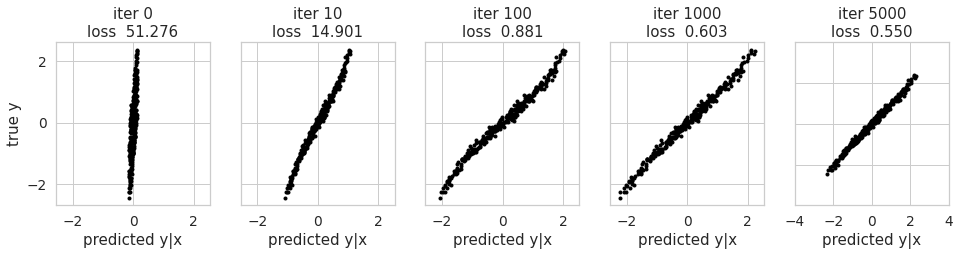

In [44]:
_, axgrid = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(16, 3))
for ii, iternum in enumerate([0, 10, 100, 1000, 5000]):
    yhat_N = predict_y_given_x_with_NN(x_ND, fromrand_history['param_values'][iternum])
    ax = axgrid[ii]
    ax.plot(yhat_N, y_N, 'k.')

    if ii == 0:
        ax.set_ylabel('true y')
    ax.set_xlabel('predicted y|x');
    ax.set_xticks([-4, -2, 0, 2, 4]); ax.set_yticks([-4, -2, 0, 2, 4]);
    ax.set_title("iter %d\nloss % .3f" % (iternum, fromrand_history['loss'][iternum]))

### Concept Check 1: Does your gradient descent appear to have converged?

No

### Concept Check 2: What do you notice about sensitivity to init, step size, etc?

TODO your answer here

### Concept Check 3: Is the final neural net's performance any better than the linear model?

TODO your answer here

# Part 3: Speeding up training with `jax.jit`

JAX offers a **just-in-time** (JIT) compilation transformation, known as `jax.jit`

For more, read about JIT here:
https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html

In [45]:
print("INITIAL PARAMETERS")
pretty_print_nn_param_list(rand_nn_params)

INITIAL PARAMETERS
Layer 0
  w | shape   (2, 16) | [ 0.010  0.043  0.021  0.009 -0.015  0.029 -0.012  0.078  0.093 -0.023
  0.058  0.006  0.014  0.085 -0.086 -0.083 -0.096  0.067  0.056  0.074
  0.096  0.060 -0.008  0.056 -0.076  0.028 -0.071  0.089  0.004 -0.017
 -0.047  0.055]
  b | shape     (16,) | [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000]
Layer 1
  w | shape   (16, 1) | [ 0.010  0.043  0.021  0.009 -0.015  0.029 -0.012  0.078  0.093 -0.023
  0.058  0.006  0.014  0.085 -0.086 -0.083]
  b | shape      (1,) | [ 0.000]


## Speed test: using standard "calc_loss_and_grad"

We'll run 1000 iters of gradient descent using our 2-16-1 neural net

In [46]:
_, _ = run_many_iters_of_grad_descent(
    calc_loss_and_grad,
    rand_nn_params,
    step_size=0.0008,
    n_iters=1000,
    print_every=500)

iter    0/1000 after   0.0 sec : loss   51.275570
iter  500/1000 after   7.4 sec : loss    0.663917
iter 1000/1000 after  12.5 sec : loss    0.603375


## Speed test: using `jax.jit(calc_loss_and_grad)`

We'll run 1000 iters of gradient descent using our 2-16-1 neural net, using our FASTER jit-ified calc_loss_and_grad

In [47]:
# Prepare the faster version by calling jax.jit
fast_loss_and_grad = jax.jit(calc_loss_and_grad)

# Call it once, might help speedup future calls
fast_loss_and_grad(rand_nn_params);

In [48]:
_, _ = run_many_iters_of_grad_descent(
    fast_loss_and_grad,
    rand_nn_params,
    step_size=0.0008,
    n_iters=1000,
    print_every=500)

iter    0/1000 after   0.0 sec : loss   51.275570
iter  500/1000 after   0.1 sec : loss    0.663917
iter 1000/1000 after   0.1 sec : loss    0.603375


### Exercise 3A: How much speedup did you observe?

On your instructors' late 2019 macbook pro, we see that `jit` yields a speedup of roughly 50-60x


In [49]:
((12.5-0.1)/12.5)*100

99.2